In [1]:
import os
import argparse
import json
from os import path
from copy import deepcopy

from utils import *

from dataloaders import dataloader_factory
from scheduler.utils import *

from collections import Counter
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
from pathlib import Path

device = 'cpu'
figure_type = 'ed'
model_code = 'gru4rec'

type_list = ["base_2022", "base_2021", "partial_2000", "partial_2001", "dvae", "ed", "ep"]

suffix = ["base_2022", "base_2021", "base_partial_2022", "base_partial_2022", "dvae", "ed", "ep"]

model_base_path = ["___el_" + s for s in suffix]
primary_keywords = ["gru4rec", "gru4rec", "gru4rec-rate-0.8-seed-2000", "gru4rec-rate-0.8-seed-2001", "gru4rec", "gru4rec", "gru4rec"]
secondary_keywords = ["gru4rec", "gru4rec", "gru4rec", "gru4rec", "teacher", "student", "student"]

def dir_finder(path: Path, keyword):
    for child in path.iterdir():
        if child.is_dir() and keyword in child.name:
            yield child

model_path_dict = {}
config_path_dict = {}

rt = Path(".")

for type_, base_path, primary_key, secondary_key in zip(type_list, model_base_path, primary_keywords, secondary_keywords):
    base = rt.joinpath(base_path)
    primary_path = next(dir_finder(base, primary_key))
    secondary_path = next(dir_finder(primary_path, secondary_key))
    secondary_p = secondary_path.joinpath('checkpoint', 'best_acc_model.pth') # model path
    if not secondary_p.exists():
        raise FileNotFoundError(secondary_p)
    model_path_dict[type_] = secondary_p
    
    config_path = primary_path.joinpath('config.json')
    if not config_path.exists():
        raise FileNotFoundError(config_path)
    
    config_path_dict[type_] = config_path

In [3]:
def get_args(tp):
    with open(path.normpath(config_path_dict[tp ]), 'r') as f:
        args = argparse.Namespace()
        args.__dict__.update(json.load(f))
        if args.kwargs is not None:
            args.__dict__.update(args.kwargs)

    args.do_sampling = False
    
    return args

base_args = get_args('base_2022')

In [4]:
train_loader, val_loader, test_loader, dataset = dataloader_factory(base_args)

item_train, item_valid, item_test, usernum, itemnum, rating_train, rating_valid, rating_test = dataset

In [5]:
def get_model_with_weight(model_code, model_path, args):
    model = generate_model(args, model_code, dataset, device)
    load_state_from_given_path(model, model_path, device, must_exist=True)
    
    return model

In [9]:
def get_teacher_model(tp='base'):
    from models.Ensembler import Ensembler

    if tp in ["base", "dvae"]:
        model = get_model_with_weight(model_code, model_path_dict['base_2022'] if tp == 'base' else model_path_dict['dvae'], base_args)
    else:
        if tp == 'ed':
            model1 = get_model_with_weight(model_code, model_path_dict['base_2021'], base_args)
            model2 = get_model_with_weight(model_code, model_path_dict['base_2022'], base_args)

            ed_args = get_args('ed')

            T = ed_args.T
        elif tp == 'ep':
            model1 = get_model_with_weight(model_code, model_path_dict['partial_2000'], base_args)
            model2 = get_model_with_weight(model_code, model_path_dict['partial_2001'], base_args)

            ep_args = get_args('ep')

            T = ep_args.T

        model = Ensembler(device, [model1, model2], temp=T)
    
    return model

In [12]:
def get_data(model, uk=100, ik=100):
    model.eval()

    score_batch_list = []
    user_batch_list = []

    score_all = None
    users = None

    iterator = tqdm(test_loader)
#     itertor = test_loader

    cnt = 1

    MOD = len(iterator) // 20

    for batch in iterator:
        if device == 'cuda':
            batch = [x.to('cuda') for x in batch]
        with torch.no_grad():
            if score_all is None:
                score_all = model.full_sort_predict(batch)
                users = batch[-1]
            else:
                _score = model.full_sort_predict(batch)
                _user = batch[-1]
                score_all = torch.cat([score_all, _score])
                users = torch.cat([users, _user])

            if cnt % MOD == 0:
                score_batch_list.append(score_all)
                user_batch_list.append(users)

                score_all = None
                users = None

            cnt += 1

    score_all = torch.cat(score_batch_list)
    users = torch.cat(user_batch_list)

    selected_score = score_all[:uk].cpu()
    selected_topk = selected_score.topk(ik, dim=1)
    softmaxed_topk = torch.softmax(selected_topk.values, dim=1)

    return softmaxed_topk

In [13]:
bs = get_teacher_model('base')
ed = get_teacher_model('ed')
ep = get_teacher_model('ep')
dvae = get_teacher_model('dvae')

data1 = get_data(bs)
data2 = get_data(ed)
data3 = get_data(ep)
data4 = get_data(dvae)

100%|██████████| 400/400 [04:30<00:00,  1.48it/s]


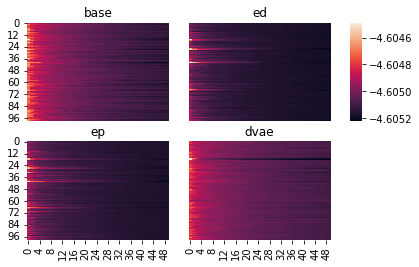

In [24]:
fig, axs = plt.subplots(2, 3, gridspec_kw={'width_ratios': [1,1,0.08]})

axs[0, 0].get_shared_y_axes().join(axs[0, 1])
axs[1, 0].get_shared_y_axes().join(axs[1, 1])

axs[0, 0].title.set_text('base')
axs[0, 1].title.set_text('ed')
axs[1, 0].title.set_text('ep')
axs[1, 1].title.set_text('dvae')

s1 = sns.heatmap(torch.log(data1[:, :50]), ax=axs[0, 0], cbar=False, xticklabels=False)
s1.set_xlabel('')
s1.set_ylabel('')
s2 = sns.heatmap(torch.log(data2[:, :50]), ax=axs[0, 1], cbar_ax=axs[0, 2], xticklabels=False)
s2.set_xlabel('')
s2.set_ylabel('')
s2.set_yticks([])

s3 = sns.heatmap(torch.log(data3[:, :50]), ax=axs[1, 0], cbar=False)
s3.set_xlabel('')
s3.set_ylabel('')
s4 = sns.heatmap(torch.log(data4[:, :50]), ax=axs[1, 1], cbar=False)
s4.set_xlabel('')
s4.set_ylabel('')
s4.set_yticks([])

for ax in [s1, s2, s3, s4]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

axs[-1,-1].axis('off')

plt.savefig('./ablation/heatmap_of_four.png')

In [22]:
plt.show()